# Download data streams for given watershed

A list of available data streams:

|Data stream|Sources|Query keys|Example|
|----|----|----|---|
|Hydrography|National Hydrography Dataset for river network|`NHD`,`NHD Plus`|`sources['hydrography'] = workflow.source_list.hydrography_sources['NHD']`|
|HUC|National Hydrography Dataset for watershed boundary|`WBD`, `NHD`, `NHD Plus`|`sources['HUC'] = workflow.source_list.huc_sources['WBD']`|
|DEM|National Elevation Dataset (NED) for elevation|`NED 1/3 arc-second`: 10 m reso.,`NED 1 arc-second`: 30 m reso.|`sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']`|
|Land cover|National Land Cover Database (NLCD) for land cover/transpiration/rooting depths|`NLCD (L48)`: CONUS,`NLCD (AK)`: Alaska|`sources['land cover'] = workflow.source_list.land_cover_sources['NLCD (L48)']`|
|Soil type|National Resources Conservation Service (NRCS) Soil Survey data for soil types|`NRCS SSURGO`, statsgo?|`sources['soil type'] = workflow.source_list.soil_sources['NRCS SSURGO']`|
|Daymet|Meteorology data from [ORNL DAAC](https://daymet.ornl.gov/), 1 km resolution|`DayMet`|`sources['meteorology'] = workflow.source_list.met_sources['DayMet']`|



In [1]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import fiona
from osgeo import gdal

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs
import workflow.sources.manager_nrcs
import matplotlib.cm

workflow.ui.setup_logging(1,None) # default is printing logging.INFO
# figsize = (6,6)
# figsize_3d = (8,6)

In [29]:
watershed_name = 'Yakima'
watershed_shapefile = '../data/hydrologic_units/hanford/yakima.shp'

# watershed_shapefile = "../data/hydrologic_units/Maumee/EagleCreek_reproj.shp"
# watershed_name = 'EagleCreek'
fname_dem_asc = './results/{}_watershed.asc'.format(watershed_name)
fname_dem_tiff = './results/{}_DEM-10m.tiff'.format(watershed_name)
fname_lc_tiff = './results/{}_LandCover.tiff'.format(watershed_name)
fname_soil_tiff = './results/{}_SoilType.tiff'.format(watershed_name)
fname_wbn_shp = './results/{}_WBN.shp'.format(watershed_name)

In [4]:
def hillshade(array, azimuth, angle_altitude):

    """
    Add shades to the contour map.
    Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html
    
    Parameters:
    ----
    array: dem numpy 2D array
    
    """ 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [4]:
# hint = '0410'  # hint: HUC 4 containing this shape.  
#                # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Watershed shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)

logging.info("CRS: {}".format(crs))

2020-09-17 16:59:38,150 - root - INFO: 
2020-09-17 16:59:38,152 - root - INFO: Watershed shape: ../data/hydrologic_units/hanford/yakima.shp
2020-09-17 16:59:38,152 - root - INFO: ==============================
2020-09-17 16:59:38,153 - root - INFO: 
2020-09-17 16:59:38,153 - root - INFO: Preprocessing Shapes
2020-09-17 16:59:38,154 - root - INFO: ------------------------------
2020-09-17 16:59:38,154 - root - INFO: loading file: "../data/hydrologic_units/hanford/yakima.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:331: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)
2020-09-17 16:59:38,338 - root - INFO: CRS: EPSG:2856


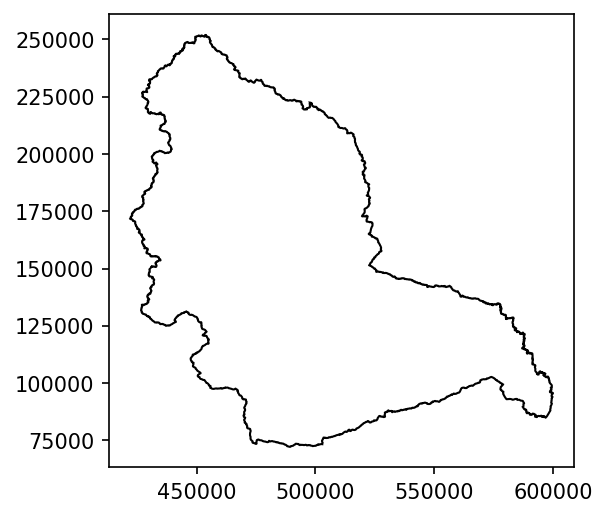

In [19]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

2020-09-17 16:59:48,440 - root - INFO: Using sources:
2020-09-17 16:59:48,441 - root - INFO: --------------
2020-09-17 16:59:48,442 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-09-17 16:59:48,442 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-09-17 16:59:48,443 - root - INFO: DEM: National Elevation Dataset (NED)
2020-09-17 16:59:48,443 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-09-17 16:59:48,444 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-09-17 16:59:48,444 - root - INFO: soil thickness: None
2020-09-17 16:59:48,445 - root - INFO: meteorology: DayMet 1km


# DEM

Currently, `30-m` and `10-m` DEM is available everywhere in the US. `1-m` DEM is only available in a few places such as Maumee watershed. Checkout the [Elevation products availability map](https://viewer.nationalmap.gov/basic/).

- `1-m` DEM query needs to be implemented

## Download DEM

In [14]:
# use 10-m DEM instead
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']

In [15]:
# get a raster for the elevation map, based on NED
dem_profile, dem_raster = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, 
                                                raster_crs=crs, mask=True, nodata=np.nan)

2020-09-16 16:07:54,476 - root - INFO: 
2020-09-16 16:07:54,477 - root - INFO: Preprocessing Raster
2020-09-16 16:07:54,477 - root - INFO: ------------------------------
2020-09-16 16:07:54,482 - root - INFO: collecting raster
2020-09-16 16:07:54,813 - root - INFO: Collecting DEMs to tile bounds: [-121.53268060202119, 45.97279311404202, -119.19510656603516, 47.60780473235191]
2020-09-16 16:07:54,814 - root - INFO:   Need:
2020-09-16 16:07:54,814 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n46_w122.img
2020-09-16 16:07:54,815 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n46_w121.img
2020-09-16 16:07:54,815 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n46_w120.img
2020-09-16 16:07:54,816 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n47_w122.img
2020-09-16 16:07:54,816 - 

## Plot DEM

The plotting follows this [post](http://geologyandpython.com/dem-processing.html), which adds hillslope shades to the contour map.

In [98]:
# note the bound is from upper left to lower right
x0, y1= dem_profile['transform'] * (0,0)
x1, y0 = dem_profile['transform'] * (dem_profile['width'], dem_profile['height'])

extent = x0, x1, y0, y1

vmin,vmax = np.nanmin(dem_raster),np.nanmax(dem_raster)

<ipython-input-17-817b0e4be5a1>:12: RuntimeWarning: invalid value encountered in sin
  shaded = np.sin(altituderad) * np.sin(slope) \
<ipython-input-17-817b0e4be5a1>:13: RuntimeWarning: invalid value encountered in cos
  + np.cos(altituderad) * np.cos(slope) \
<ipython-input-17-817b0e4be5a1>:14: RuntimeWarning: invalid value encountered in cos
  * np.cos(azimuthrad - aspect)


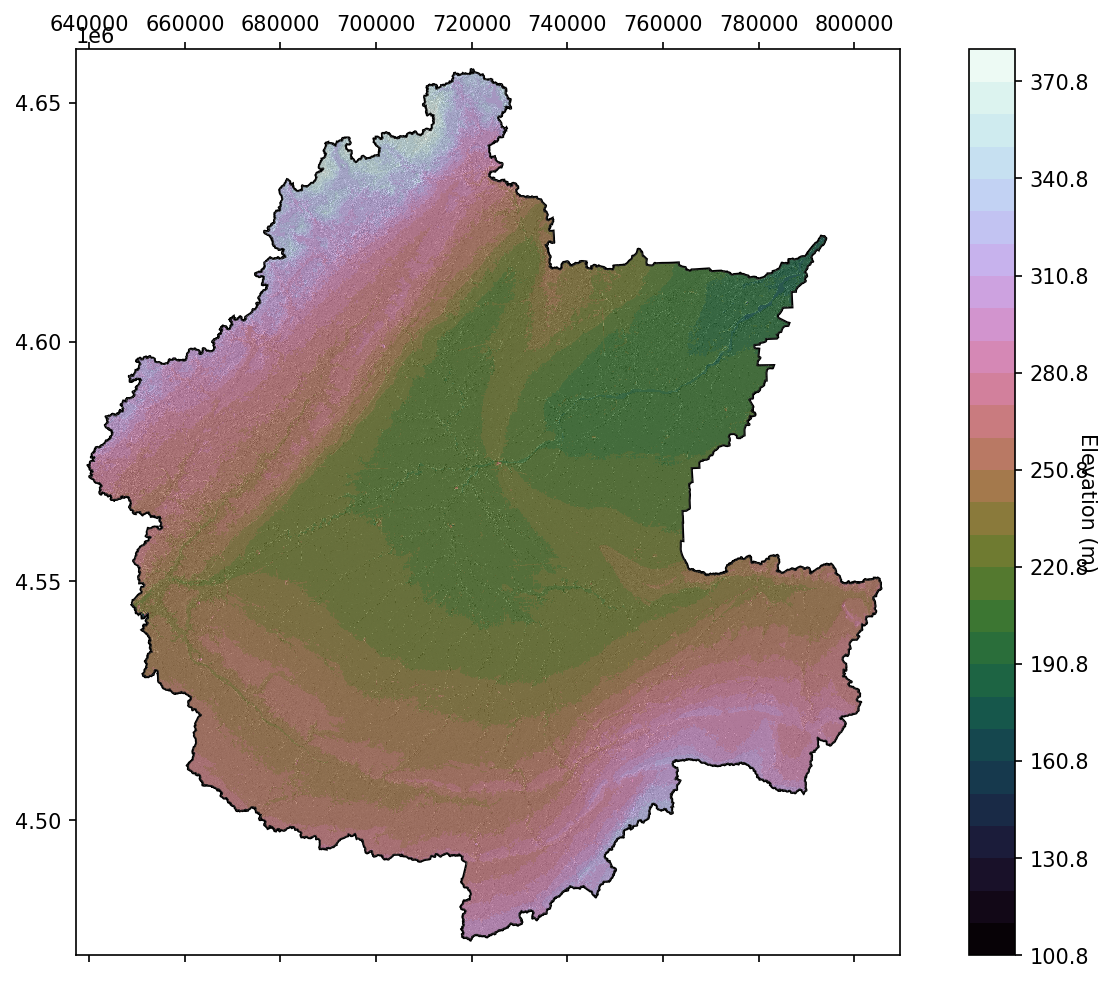

In [100]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
ax.matshow(hillshade(dem_raster, 330, 30), extent=extent, cmap='Greys', alpha=.3, zorder=10)

cax = ax.contourf(dem_raster, np.arange(vmin, vmax, 10),extent=extent, 
                  cmap='cubehelix', vmin=vmin, vmax=vmax, origin='image')
# __apply_grid_to_axis(ax)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Elevation (m)',rotation=270)

## Export DEM

Export DEM to ASCII/TIFF format for visualization in QGIS.

In [16]:
ncols = dem_profile['width']
nrows = dem_profile['height']
xllcorner = x0
yllcorner = y0
cellsize = (x1-x0)/ncols
nodata = -9999

In [17]:
data = np.nan_to_num(dem_raster, nan = -9999)

- **ASCII**

In [56]:
TheFile=open(fname_dem_asc,"w")
TheFile.write("ncols {}\n".format(ncols))
TheFile.write("nrows {}\n".format(nrows))
TheFile.write("xllcorner {}\n".format(xllcorner))
TheFile.write("yllcorner {}\n".format(yllcorner)) 
TheFile.write("cellsize {:.3f}\n".format(cellsize)) 
TheFile.write("NODATA_value  {}\n".format(nodata))

for i in np.arange(nrows):
    TheFile.write(" ".join(str(j) for j in data[i, :]))
    TheFile.write("\n")

TheFile.close()

- **GeoTIFF**

In [18]:
geotrans = dem_profile['transform']
proj = dem_profile['crs']

In [19]:
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(fname_dem_tiff, ncols, nrows, 1, gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(data)
dataset.GetRasterBand(1).SetNoDataValue(nodata)

dataset.SetGeoTransform(geotrans.to_gdal()) # accepted format(xmin, dx, 0, ymax, 0, -dx)
dataset.SetProjection(proj.to_wkt())

dataset.FlushCache() # write to disk
dataset=None # close file

# Watershed Boundary

In [6]:
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']

huc = "1703"

In [7]:
wbn_crs, wbn = workflow.get_hucs(sources['HUC'], huc, crs = crs)                                    

2020-09-17 17:00:00,665 - root - INFO: 
2020-09-17 17:00:00,666 - root - INFO: Preprocessing HUC
2020-09-17 17:00:00,667 - root - INFO: ------------------------------
2020-09-17 17:00:00,667 - root - INFO: Loading level 4 HUCs in 1703.
2020-09-17 17:00:00,669 - root - INFO: Using HUC file "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2020-09-17 17:00:00,714 - root - INFO:   found 4 HUCs.
2020-09-17 17:00:00,715 - root - INFO:   geometry type <class 'dict'> 
2020-09-17 17:00:00,715 - root - WARNING: only 1 fiona obj is found!
2020-09-17 17:00:00,716 - root - INFO:   -- 1703
2020-09-17 17:00:01,023 - root - INFO: convert fiona obj to shapely...


## plot

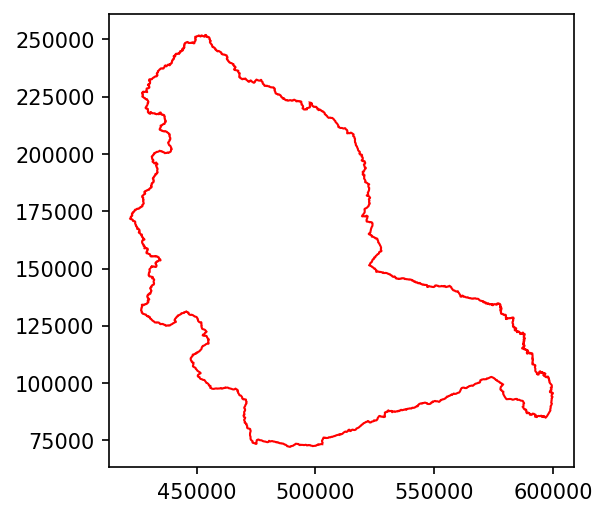

In [21]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)

## export

See this [post](https://gis.stackexchange.com/questions/52705/how-to-write-shapely-geometries-to-shapefiles) for saving shapely geometry to a .shp file.

In [23]:
from osgeo import ogr
from shapely.geometry import mapping

In [24]:
wbn_f = dict(geometry=mapping(wbn))

In [30]:
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

In [31]:
with fiona.open(fname_wbn_shp, 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(wbn),
        'properties': {'id': 1},
    })

# Hydrograph

Download river network from USGS NHD dataset using [REST API]( https://viewer.nationalmap.gov/tnmaccess/api/products). This will download watershed boundary (WBD) at all HUC levels, as well as flowlines (layer name: `NHDFlowline`).

>     Watershed Workflow leverages the Watershed Boundary Dataset (WBD) and the
    National Hydrography Dataset (NHD), USGS and EPA datasets available at
    multiple resolutions to represent United States watersheds, including
    Alaska [NHD]_.  Also used is the NHD Plus dataset, an augmented dataset
    built on watershed boundaries and elevation products.  By default, the
    1:100,000 High Resolution datasets are used.  Data is discovered through
    The National Map's [TNM]_ REST API, which allows querying for data files
    organized by HUC and resolution via HTTP POST requests, providing
    direct-download URLs.  Files are downloaded on first request, unzipped, and
    stored in the data library for future use.  Currently, files are indexed by
    2-digit (WBD), 4-digit (NHD Plus HR) and 8-digit (NHD) HUCs.

    .. [NHD] https://www.usgs.gov/core-science-systems/ngp/national-hydrography
    .. [TNM] (https://viewer.nationalmap.gov/help/documents/TNMAccessAPIDocumentation/TNMAccessAPIDocumentation.pdf)
    
See [NHD website](https://www.usgs.gov/core-science-systems/ngp/national-hydrography) and [TNM access guide](https://viewer.nationalmap.gov/help/documents/TNMAccessAPIDocumentation/TNMAccessAPIDocumentation.pdf).

Note: 
- NHDPlus HR uses data at 1:24,000 scale or better, and the 1/3 arc-second (10-m) DEM.
- Not all HUC4 can be queried using `NHD Plus`. Most watersheds have high res NHD such as "0601". A few within HUC2="04" are not available as of Sep. 2020. Checkout the latest availability at [National Hydrography Dataset Plus High Resolution Availability Web Map](https://usgs.maps.arcgis.com/apps/MapTools/index.html?appid=41a5c2ca49bd4a83b239450e61022d53).
- Currently the default `NHD` only supports querying one single HUC8 or smaller watershed.

In [15]:
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD']

# huc = "17030001" # HUC4 for NHD Plus or HUC8 for NHD
huc = "1703"

**caution: the CRS convertion takes long time to finish**. If just want to download the data source, try `cvrt = False`.

In [16]:
reach_crs, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, 
                                          cvrt = False,
                                  merge = False)

2020-09-17 16:36:16,026 - root - INFO: 
2020-09-17 16:36:16,027 - root - INFO: Preprocessing Hydrography
2020-09-17 16:36:16,027 - root - INFO: ------------------------------
2020-09-17 16:36:16,028 - root - INFO: Loading streams in HUC 1703
2020-09-17 16:36:16,029 - root - INFO:          and/or bounds (422043.4179180811, 72197.09398879118, 599959.3691231109, 251895.81705080863)
2020-09-17 16:36:16,031 - root - INFO: Using Hydrography file "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2020-09-17 16:36:18,653 - root - INFO:   found 63359 reaches
2020-09-17 16:36:18,654 - root - INFO: out crs: EPSG:4269
2020-09-17 16:36:18,655 - root - INFO: convert to 63359 shapely files


## plot river network

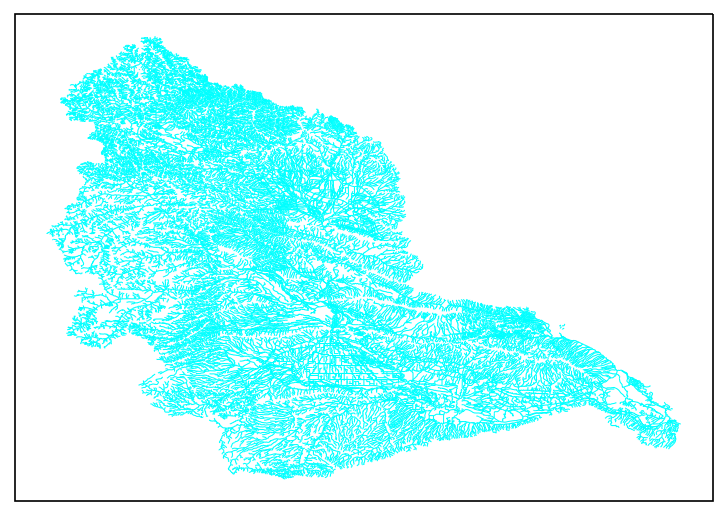

In [14]:
fig = plt.figure(figsize=(6,6))
ax = workflow.plot.get_ax(crs, fig)

# workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.shply(reaches, crs, ax=ax, color='aqua', linewidth=0.5)

plt.show()

# Land Cover

View available land cover sources and legend at [Multi-resolution Land Characteristics Consortium map viewer](https://www.mrlc.gov/viewer/). Current land cover resolution is 30-m.

- For the first time, this will download the entire land cover dateset for US!! ~100 GB. 


In [6]:
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                    raster_crs=crs, 
                                                     mask=True, 
                                                     nodata=np.nan)

2020-09-16 09:46:01,724 - root - INFO: 
2020-09-16 09:46:01,725 - root - INFO: Preprocessing Raster
2020-09-16 09:46:01,725 - root - INFO: ------------------------------
2020-09-16 09:46:01,735 - root - INFO: collecting raster
2020-09-16 09:46:01,744 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-09-16 09:46:02,715 - root - INFO: Got raster of shape: (1, 6100, 5547)
2020-09-16 09:46:03,766 - root 

## plot land cover

Note: the plotting can be extremely slow due to large land cover array.

In [7]:
# note the bound is from upper left to lower right
x0, y1= lc_profile['transform'] * (0,0)
x1, y0 = lc_profile['transform'] * (lc_profile['width'], lc_profile['height'])

extent = x0, x1, y0, y1

# vmin,vmax = np.nanmin(lc_raster),np.nanmax(lc_raster)

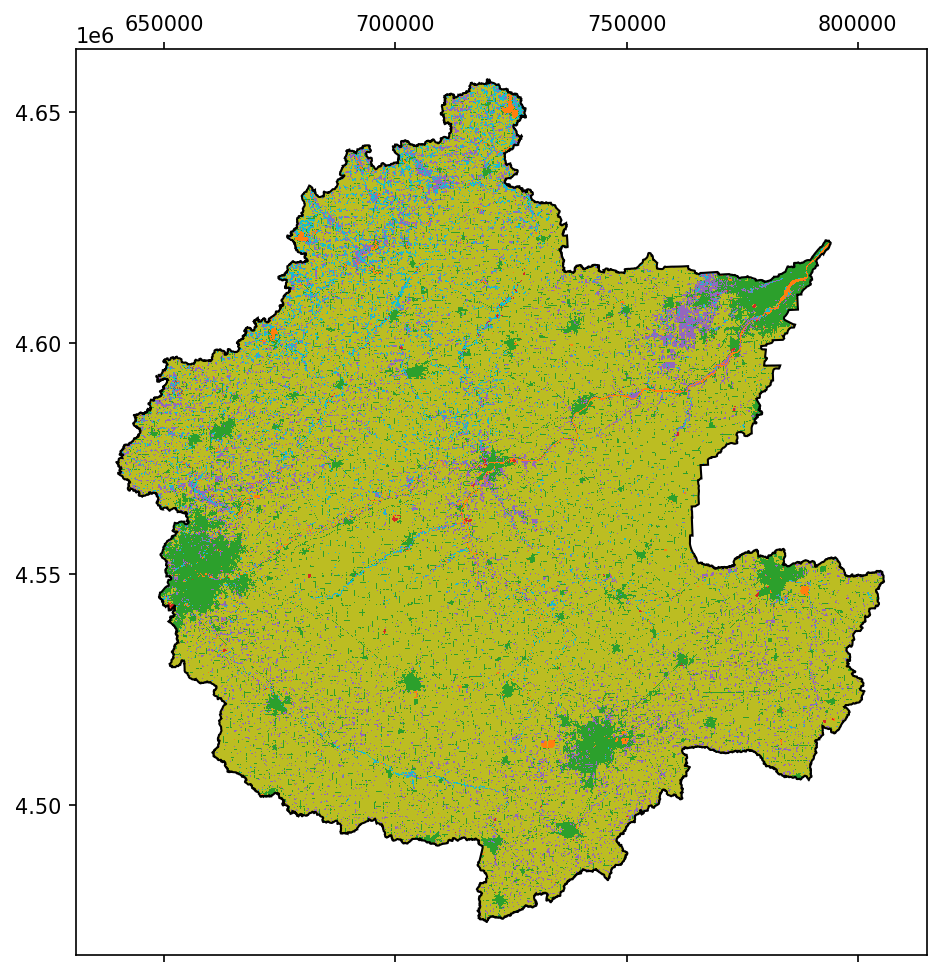

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.matshow(lc_raster, extent=extent, cmap='tab10', alpha=1)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

### export to TIF

In [26]:
ncols = lc_profile['width']
nrows = lc_profile['height']
# xllcorner = x0
# yllcorner = y0
# cellsize = (x1-x0)/ncols
nodata = -9999

data = np.nan_to_num(lc_raster, nan = -9999)

geotrans = lc_profile['transform']
proj = lc_profile['crs']

In [27]:
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(fname_lc_tiff, ncols, nrows, 1, gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(data)
dataset.GetRasterBand(1).SetNoDataValue(nodata)

dataset.SetGeoTransform(geotrans.to_gdal()) # accepted format(xmin, dx, 0, ymax, 0, -dx)
dataset.SetProjection(proj.to_wkt())

dataset.FlushCache() # write to disk
dataset=None # close file

# Soil type

The request may fail on larger watersheds (i.e., Maumee).

In [ ]:
# -- download the shapes, return a list of shapely geometry
target_bounds = watershed.exterior().bounds
soil_crs, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

In [73]:
# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

Resample the soil type polygons into a raster matrix

In [74]:
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, target_dx=10, 
                                              shapes = soil_survey,
                                              shape_colors=soil_ids, shapes_crs=crs,
                                              nodata=-9999)

2020-09-15 21:47:17,896 - root - INFO: Coloring shapes onto raster:
2020-09-15 21:47:17,896 - root - INFO:   target_bounds = (773799.0395860532, 4514649.7711774735, 786730.2144690449, 4548658.917701305)
2020-09-15 21:47:17,897 - root - INFO:   out_bounds = [773794.0, 4514654.0, 786744.0, 4548664.0]
2020-09-15 21:47:17,897 - root - INFO:   pixel_size = 10
2020-09-15 21:47:17,897 - root - INFO:   width = 1295, height = 3401
2020-09-15 21:47:17,899 - root - INFO:   and 103 independent colors of dtype int32


## plotting

- the accepted extent for `imshow/matshow` is `[xmin, xmax, ymin, ymax]`, whereas the bound is in `[xmin, ymin, xmax, ymax]`.

In [82]:
extent = img_bounds[0], img_bounds[2], img_bounds[1], img_bounds[3]

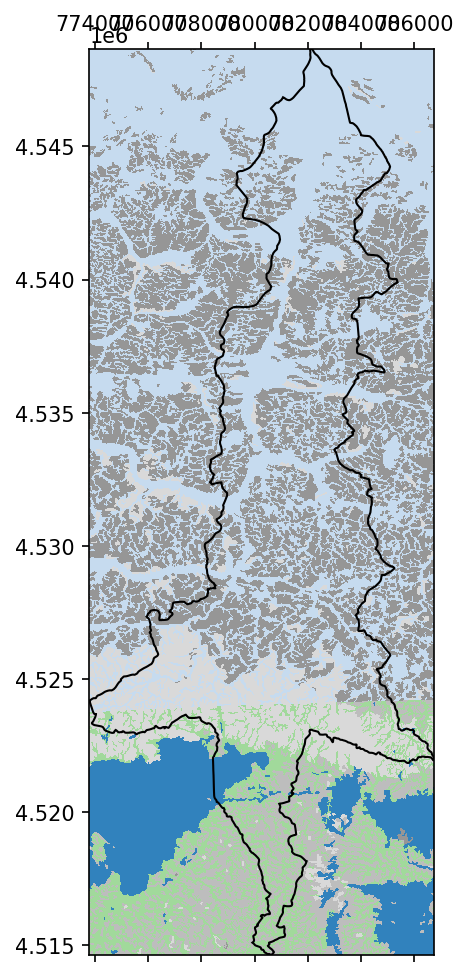

In [84]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1, 1)

ax.matshow(soil_color_raster, 
          origin = 'upper',
          extent=extent, 
          cmap='tab20c', alpha=1)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

## export to TIFF

In [76]:
ncols = soil_color_profile['width']
nrows = soil_color_profile['height']
# xllcorner = x0
# yllcorner = y0
# cellsize = (x1-x0)/ncols
nodata = soil_color_profile['nodata']

In [9]:
# data = np.nan_to_num(lc_raster, nan = -9999)

In [77]:
data = soil_color_raster

In [78]:
geotrans = soil_color_profile['transform']
proj = soil_color_profile['crs']

In [79]:
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(fname_soil_tiff, ncols, nrows, 1, gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(data)
dataset.GetRasterBand(1).SetNoDataValue(nodata)

dataset.SetGeoTransform(geotrans.to_gdal()) # accepted format(xmin, dx, 0, ymax, 0, -dx)
dataset.SetProjection(proj.to_wkt())

dataset.FlushCache() # write to disk
dataset=None # close file